## PCA with a linear Autoencoder

In [5]:
import numpy.random as rnd
import numpy as np

rnd.seed(4)
m = 200
w1, w2= 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m,3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) /2
data[:, 2] = data[:, 0] * w1 + data[:,1] * w2 + noise * rnd.randn(m)

In [6]:
# normalise the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

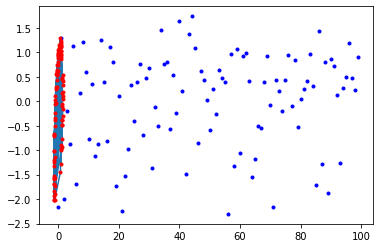

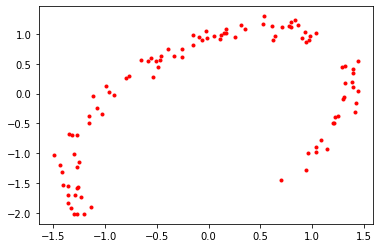

In [50]:
plt.plot(X_train[:,0], X_train[:,1], X_train[:,2], "b.")
#plt.plot(X_train[:,1], X_train[:,2], "g.")
plt.plot(X_train[:,0], X_train[:,1], "r.")
plt.show()
# looking at the dataset
plt.plot(X_train[:,0], X_train[:,1], "r.")
plt.show()

In [7]:
# building the autoencoder
import tensorflow as tf

tf.reset_default_graph()
np.random.seed(42)

n_inputs = 3 # 3D inputs
n_hidden = 2 # 2D inputs
n_outputs = n_inputs # condition for autoencoders

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None,n_inputs])
hidden = tf.layers.dense(X, n_hidden) 
# dense is equivalent of fully connected
# needs no activation for PCA
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

W0622 10:49:09.772453 18628 deprecation.py:323] From <ipython-input-7-a38fba414ab8>:14: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.
W0622 10:49:09.774447 18628 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\layers\core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


In [8]:
n_iterations = 1000
codings = hidden
# the output of hidden layer provides the codings

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X:X_train}) # no labesl given
    codings_val = codings.eval(feed_dict={X:X_test})

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:,1],"b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$",fontsize=18, rotation=0)
plt.show()

<Figure size 400x300 with 1 Axes>

## stacked autoencoder

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data")

W0622 10:49:16.838288 18628 deprecation.py:323] From <ipython-input-10-7187608d1af6>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0622 10:49:16.839284 18628 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0622 10:49:16.840281 18628 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instru

Extracting /tmp/data\train-images-idx3-ubyte.gz


W0622 10:49:17.065680 18628 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0622 10:49:17.122559 18628 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting /tmp/data\train-labels-idx1-ubyte.gz
Extracting /tmp/data\t10k-images-idx3-ubyte.gz
Extracting /tmp/data\t10k-labels-idx1-ubyte.gz


## Training all layers at once


In [11]:
# we will build a stacked Autoencoder with 3 hidden layers 
# and one output layer
# we will use ELU activation, He initialisation and L2 regularisation

tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

from functools import  partial

n_inputs = 28 * 28 # for mnist
n_hidden1 = 300
n_hidden2 = 150 # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate =0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32,shape=[None, n_inputs])
he_init = tf.contrib.layers.variance_scaling_initializer()
# He initialization

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
# l2 regularizar

my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu, #elu activation
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

# partial is agood way to define layers
# keras shold have something like this

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1,n_hidden2) # codings
hidden3 = my_dense_layer(hidden2,n_hidden3)
outputs = my_dense_layer(hidden3,n_outputs, activation=None) # no activation in output

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
# mSE

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss =tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [12]:
# training
# this is unsupervised as we not feeding y_batch
import os

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches),end= "")
            os.sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})#no y_batch
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_all_layer.ckpt")

09% Train MSE: 0.020525537
1 Train MSE: 0.01144791
29% Train MSE: 0.010235747
3 Train MSE: 0.009911384
49% Train MSE: 0.010379088


In [13]:
def plot_image(image, shape=[28,28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")

In [14]:
def plot_multiple_images(images,n_roes, n_cols, pad=2):
    images = images - images.min() 
    # making the minimum look zero so that the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w + pad) * n_rows + pad, (h + pad)* n_cols + pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y * (h + pad) + pad): (y * (h + pad) + pad + h), (x * (w + pad) + pad):(x * (w + pad) + pad + w)] = images[y * n_cols + x]
        plt.imshow(image, cmap="Greys", interpolation="nearest")
    

In [15]:
def show_reconstructed_digits(X, outputs, model_path=None,n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X:X_test})
    
    fig = plt.figure(figsize=(8,3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2+ 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

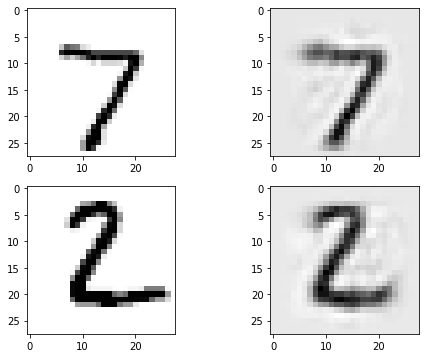

In [16]:
show_reconstructed_digits(X, outputs, "./my_model_all_layer.ckpt")

## Tying wieghts

In [17]:
# its common to tie the weights of encoder and decoder, but ut makes very difficult to use tf.layer.dense
# so we build the autoencoder manually

tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1= 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [21]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32,shape=[None,n_inputs])

weights1_init = initializer([n_inputs,n_hidden1])
weights2_init = initializer([n_hidden1,n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3") # tied weights
# these are not varibales
weights4 = tf.transpose(weights1, name="weights4") # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4") 
# biases are not tied for weights 3 and weights 4

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
# we donst regularize weights3 and weights4
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [22]:
saver = tf.train.Saver()

In [25]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            os.sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_trying_weights.ckpt")

0 Train MSE: 0.016875193
1 Train MSE: 0.015947117
2 Train MSE: 0.017239643
3 Train MSE: 0.017258577
4 Train MSE: 0.016973544


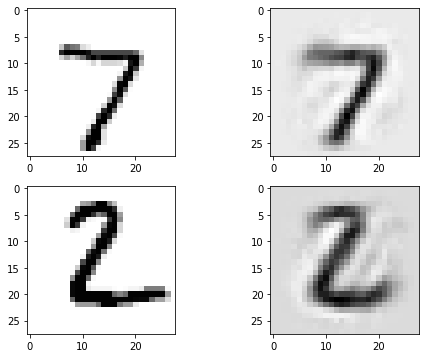

In [29]:
show_reconstructed_digits(X, outputs, "./my_model_trying_weights.ckpt")

## training one autoencoder at a time in multiple graphs

In [37]:
# the idea is to train the autoencoders seperately 
# and then using stacked autoencoder by simply initiaising it with copied weights

tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg= 0.0005, seed=42,
                      hidden_activation= tf.nn.elu,
                      output_activation= tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)
        n_inputs = X_train.shape[1]
        X = tf.placeholder(tf.float32,shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
        )
        
        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")
        
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
        
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)
        
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        
        init = tf.global_variables_initializer()
        
    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches),end="")
                os.sys.stdout.flush()
                indices= rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X:X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X:X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]
    

In [38]:
# training two autoencoders

hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300,n_epochs=4, batch_size=150, output_activation=None )
_, W2 , b2 , W3,b3 = train_autoencoder(hidden_output, n_neurons=150,n_epochs=4, batch_size=150)

09% Train MSE: 0.018122243
1 Train MSE: 0.018951437
2 Train MSE: 0.019684358
39% Train MSE: 0.019918667
0 Train MSE: 0.0043085753
19% Train MSE: 0.004446782
29% Train MSE: 0.0045360164
39% Train MSE: 0.0045574396


In [39]:
# finally we create a stacked autoencoder by simply reusing the weights and biases
# from the autoencoders we just trained

tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None,n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

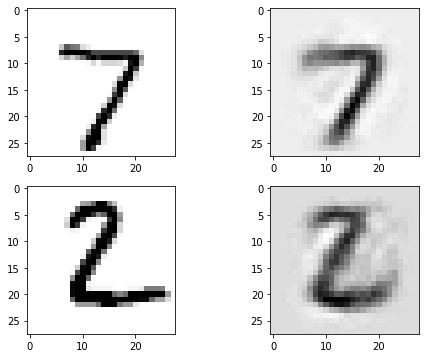

In [40]:
show_reconstructed_digits(X, outputs)

## Training one encoder at a time using a single graph

In [54]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32,shape=[None,n_inputs])

weights1_init = initializer([n_inputs,n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2,n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [55]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4
    # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1 ))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss,var_list=train_vars) # freexe hidden1

In [56]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [58]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4,4]
batch_sizes = [150,150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase +1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration //n_batches),end="" )
                os.sys.stdout.flush()
                X_batch,y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X:X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X:X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
        loss_test = reconstruction_loss.eval(feed_dict={X:mnist.test.images})
        print("test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.0077162753
1 Train MSE: 0.0076533942
2 Train MSE: 0.008064371
3 Train MSE: 0.007780215
test MSE: 0.10706358
Training phase #2
09% Train MSE: 0.53757674
19% Train MSE: 0.0052332315
2 Train MSE: 0.0028039967
3 Train MSE: 0.0022192365
test MSE: 0.009822678


In [64]:
### Cache the frozen layer outputs

training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150,150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X:mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r()%".format(100 * iteration // n_batches),end="" )
                os.sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase],feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:",loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
        loss_test = reconstruction_loss.eval(feed_dict={X:mnist.test.images})
        print("Test MSE:", loss_test)

Training phase #1
0)% Train MSE: 0.007830585
1 Train MSE: 0.007896882
2)% Train MSE: 0.007754432
3)% Train MSE: 0.0076355864
Test MSE: 0.10407364
Training phase #2
0 Train MSE: 0.15936926
1 Train MSE: 0.005739104
2)% Train MSE: 0.0023948424
3 Train MSE: 0.0020569803
Test MSE: 0.009804849


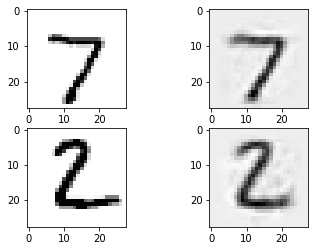

In [67]:
# visualising the reconnstruction

n_test_digits =2
X_test =mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt")
    # not shown in the book
    outputs_val = outputs.eval(feed_dict={X:X_test})

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])